In [1]:

import transformers
import torch
from vllm import LLM, SamplingParams
import os
from src.llm.PredictionUtils import init_model_and_tokenizer,llm_gen

os.environ["LIBRARY_PATH"]="/usr/local/cuda-12.2/lib64/stubs:$LIBRARY_PATH"
model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"
model_id = "meta-llama/Meta-Llama-3.1-70B-Instruct"

In [2]:
tensor_parallel_size = 8
#lora推論がうまくいかない
model= LLM(model=model_id,
           enable_lora=True,
        trust_remote_code=True,
        max_model_len=2000,
        tensor_parallel_size=tensor_parallel_size,
 max_lora_rank=64,
           )

INFO 09-19 12:58:41 config.py:904] Defaulting to use mp for distributed inference
INFO 09-19 12:58:41 llm_engine.py:223] Initializing an LLM engine (v0.6.1.post2) with config: model='meta-llama/Meta-Llama-3.1-70B-Instruct', speculative_config=None, tokenizer='meta-llama/Meta-Llama-3.1-70B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=2000, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=8, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=meta-llam

Loading safetensors checkpoint shards:   0% Completed | 0/30 [00:00<?, ?it/s]


(VllmWorkerProcess pid=656768) INFO 09-19 12:59:01 model_runner.py:1008] Loading model weights took 16.4634 GB
INFO 09-19 12:59:01 model_runner.py:1008] Loading model weights took 16.4634 GB
(VllmWorkerProcess pid=656772) INFO 09-19 12:59:01 model_runner.py:1008] Loading model weights took 16.4634 GB
(VllmWorkerProcess pid=656766) INFO 09-19 12:59:02 model_runner.py:1008] Loading model weights took 16.4634 GB
(VllmWorkerProcess pid=656769) INFO 09-19 12:59:02 model_runner.py:1008] Loading model weights took 16.4634 GB
(VllmWorkerProcess pid=656770) INFO 09-19 12:59:02 model_runner.py:1008] Loading model weights took 16.4634 GB
(VllmWorkerProcess pid=656771) INFO 09-19 12:59:03 model_runner.py:1008] Loading model weights took 16.4634 GB
(VllmWorkerProcess pid=656767) INFO 09-19 12:59:03 model_runner.py:1008] Loading model weights took 16.4634 GB
INFO 09-19 12:59:10 distributed_gpu_executor.py:57] # GPU blocks: 81384, # CPU blocks: 6553
(VllmWorkerProcess pid=656768) INFO 09-19 12:59:14 

In [3]:
from vllm.lora.request import LoRARequest

In [4]:

from datasets import load_dataset

ds=load_dataset("kanhatakeyama/material-properties",split="train")
ds=ds.shuffle(seed=1)
len(ds)

7241

In [5]:

train_ds=ds.select(range(7000))
test_ds=ds.select(range(7000,7200))
train_ds[0]


{'CompName': 'unknown',
 'SMILES': 'CC1=CC=C(C=C1)O',
 'Property': 'Vapor pressure',
 'Value': 0.11,
 'unit': '[kPa]',
 'Source': 'Wikipedia/Wikidata'}

In [6]:
import transformers
tokenizer=transformers.AutoTokenizer.from_pretrained(model_id)

In [7]:
import random
prompt_list=[]
problems=[]
n_records=200
for i in range(n_records):
    record=random.choice(test_ds)
    q=f"Predict "+record["Property"]+" "+record["unit"]+" for "+record["CompName"]+" (Compound X) with SMILES "+str(record["SMILES"])+". The prediction consists of #Reason and #Prediction. The #Reason is the quantitative explanation of the prediction. The #Prediction is the predicted value and the unit of the prediction."
    messages=[
        {"role": "user", "content": q},
    ]
    prompt=tokenizer.apply_chat_template(messages,tokenize=False)
    prompt_list.append(prompt+ "assistant\n\n#Reason\n")
    problems.append(record)

prompt_list[0]

'<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 Jul 2024\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nPredict Density [g/cm3] for unknown (Compound X) with SMILES C1CCC2(CCCCC2(C1)[H])[H]. The prediction consists of #Reason and #Prediction. The #Reason is the quantitative explanation of the prediction. The #Prediction is the predicted value and the unit of the prediction.<|eot_id|>assistant\n\n#Reason\n'

In [8]:
def predict_lora(model,prompt_list,
        lora_model,lora_id):
    print("using: ",lora_model)
    outputs = model.generate(
        prompt_list,
        SamplingParams(
        temperature=0.0,
        max_tokens=1024,
    ),
        lora_request=LoRARequest("adapter", lora_id, lora_path=lora_model)
    )

    predicted_texts=[i.outputs[0].text.strip() for i in outputs]
    return predicted_texts

In [9]:
def parse_prediction(predicted_texts):
    predicted_vals=[]
    good_records=[]
    for i in range(len(predicted_texts)):
        pred=predicted_texts[i].split("#Prediction")[-1]
        pred=pred.split(" [")[0].strip()

        strip_list=[
            "kJ/mol",
            "°C"," oC"," g/cm3"," g/cm"," eV"," cm^3/mol"," × 10^-6",
        ]
        for s in strip_list:
            pred=pred.split(s)[0].strip()

        if " " in pred:
            pred=pred.split(" ")[-1]
        if "\n" in pred:
            pred=pred.split("\n")[-1]
        if "**" in pred:
            pred=pred.split("**")[-1]
        
        predicted_vals.append(pred)

        problems[i]["predicted"]=pred
        problems[i]["predicted_text"]=predicted_texts[i]
        try:
            problems[i]["Value"]=float(problems[i]["Value"])
            error = abs((problems[i]["Value"]-float(problems[i]
                        ["predicted"]))/problems[i]["Value"])
            problems[i]["error_rate"] = error
            good_records.append(problems[i])
        except Exception as e:
            print(e)
            continue

    return good_records



In [10]:

#lora_model="output_0919_threshold_0.1"
#predicted_texts=predict_lora(model,prompt_list,lora_model)
#good_records=parse_prediction(predicted_texts)

In [11]:
import glob
from tqdm import tqdm
lora_model_list=glob.glob("output_0919_threshold_0.1/checkpoint-*")
lora_model_list=glob.glob("output0919_threshold_0.1_lora_kqvo_proj/checkpoint-*")
lora_model_list= sorted(lora_model_list, key=lambda x: int(x.split('-')[-1]))

prediction_dict={}

cnt=100
for lora_model in tqdm(lora_model_list[:]):
    cnt+=1
    predicted_texts=predict_lora(model,prompt_list,lora_model,cnt)
    good_records=parse_prediction(predicted_texts)
    prediction_dict[lora_model]=good_records

  0%|          | 0/7 [00:00<?, ?it/s]/tmp/ipykernel_656637/1195523196.py:10: DeprecationWarning: The 'lora_local_path' attribute is deprecated and will be removed in a future version. Please use 'lora_path' instead.
  lora_request=LoRARequest("adapter", lora_id, lora_path=lora_model)


using:  output0919_threshold_0.1_lora_kqvo_proj/checkpoint-5


 14%|█▍        | 1/7 [01:04<06:26, 64.36s/it]

float division by zero
using:  output0919_threshold_0.1_lora_kqvo_proj/checkpoint-10


 29%|██▊       | 2/7 [02:05<05:13, 62.66s/it]

float division by zero
could not convert string to float: '49.5.0'
could not convert string to float: '169.6.0'
using:  output0919_threshold_0.1_lora_kqvo_proj/checkpoint-15


 43%|████▎     | 3/7 [03:15<04:23, 65.90s/it]

float division by zero
using:  output0919_threshold_0.1_lora_kqvo_proj/checkpoint-20


 57%|█████▋    | 4/7 [04:15<03:10, 63.51s/it]

float division by zero
using:  output0919_threshold_0.1_lora_kqvo_proj/checkpoint-25


 71%|███████▏  | 5/7 [05:26<02:12, 66.15s/it]

could not convert string to float: 'kPa'
float division by zero
could not convert string to float: '+'
using:  output0919_threshold_0.1_lora_kqvo_proj/checkpoint-30


 86%|████████▌ | 6/7 [06:26<01:04, 64.02s/it]

float division by zero
using:  output0919_threshold_0.1_lora_kqvo_proj/checkpoint-33


100%|██████████| 7/7 [07:35<00:00, 65.08s/it]

float division by zero


In [12]:
import json 
with open("data/predict/0919prediction_dict_kqvo_proj.json","w") as f:
    json.dump(prediction_dict,f,indent=2)

In [13]:
prediction_dict['output_0919_threshold_0.1/checkpoint-5'][:2]

KeyError: 'output_0919_threshold_0.1/checkpoint-5'

In [64]:

prediction_dict['output_0919_threshold_0.1/checkpoint-10'][:2]

[{'CompName': 'Ethylbenzene',
  'SMILES': 'CCc1ccccc1',
  'Property': 'Density',
  'Value': 0.8665,
  'unit': '[g/cm3]',
  'Source': 'Wikipedia/Wikidata',
  'predicted': '0.864',
  'predicted_text': "To predict the density of Compound X, let's break down the molecule into its constituent functional groups and estimate their contributions to the overall density.\n\n1. **Benzene ring (C6H6)**: The density of benzene is approximately 0.879 g/cm3. This value will serve as a starting point.\n2. **Ethyl group (C2H5)**: The addition of an ethyl group will increase the molecular weight and potentially decrease the density due to the introduction of more hydrogen atoms, which are less dense than carbon atoms. A rough estimate for the density decrease caused by an ethyl group is around -0.05 g/cm3.\n3. **Methyl group (CH3)**: Although there is no explicit methyl group in the given molecule, the ethyl group (C2H5) can be thought of as a methyl group (CH3) with an additional methylene group (CH2).

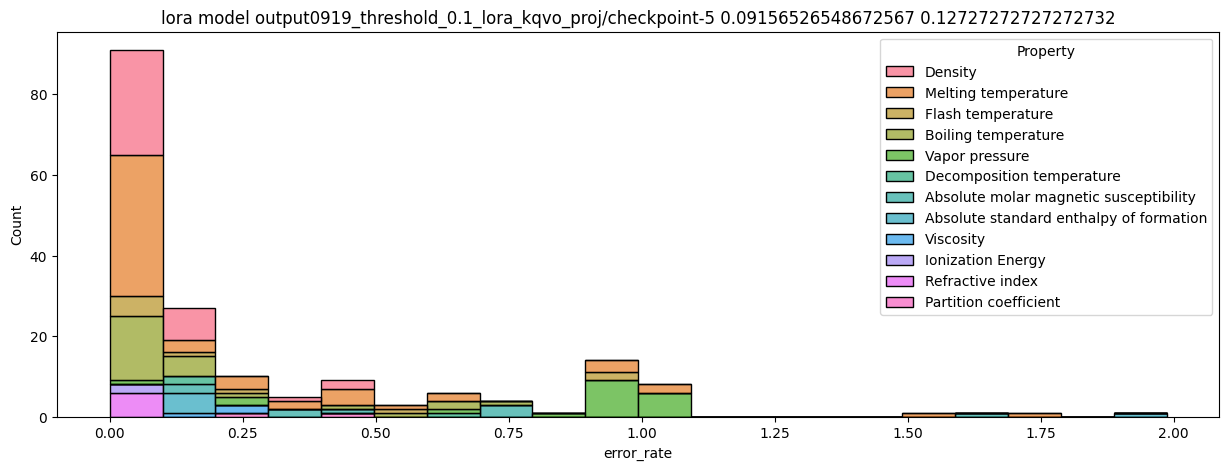

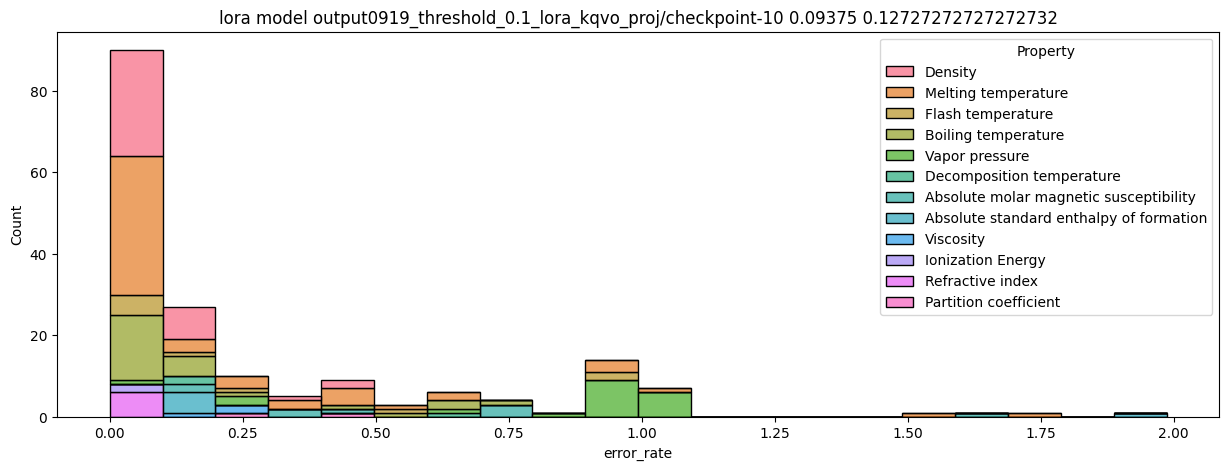

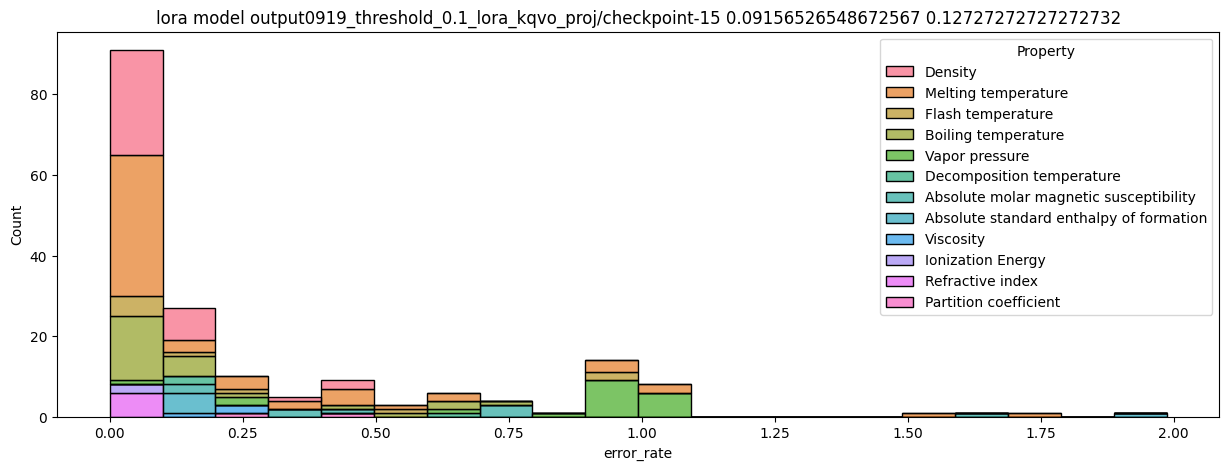

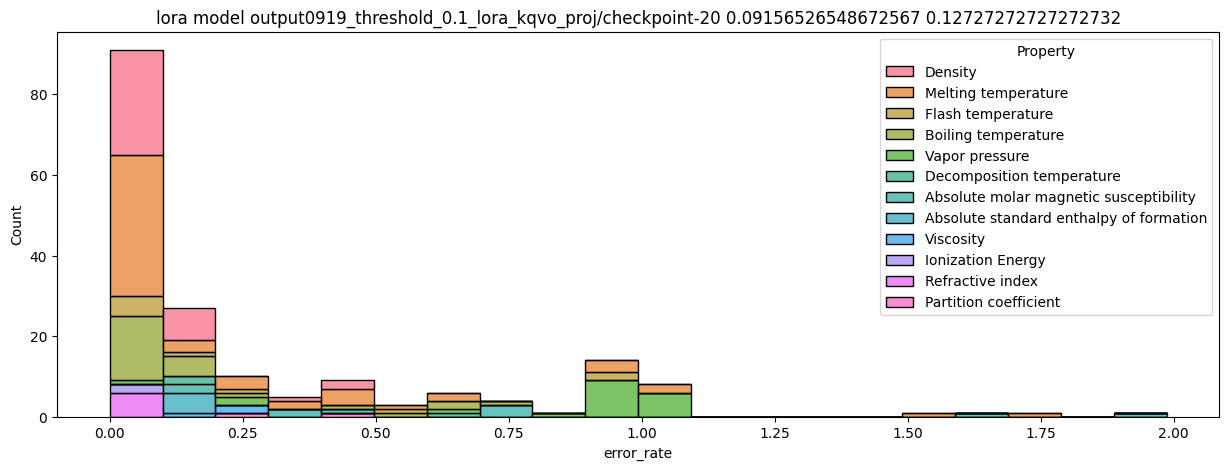

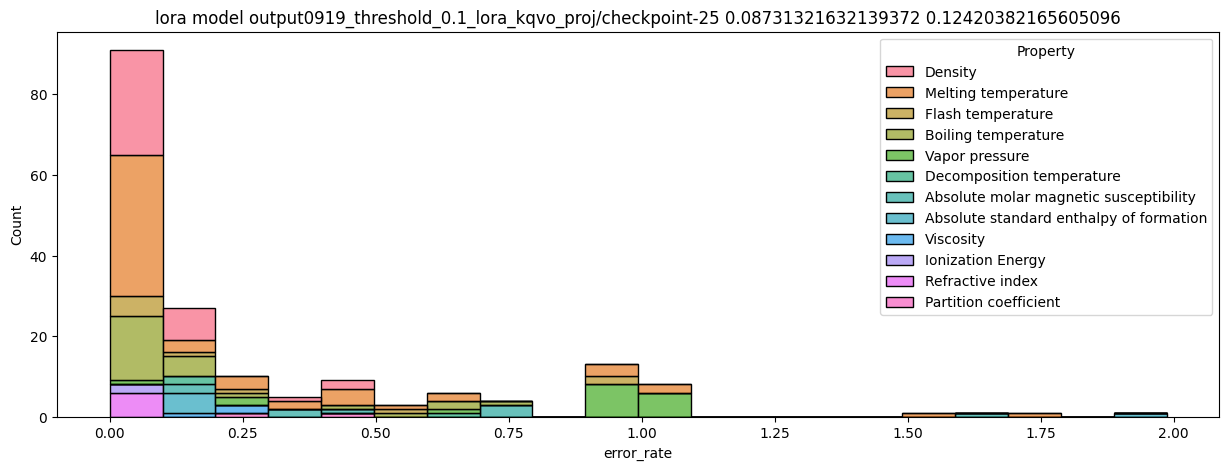

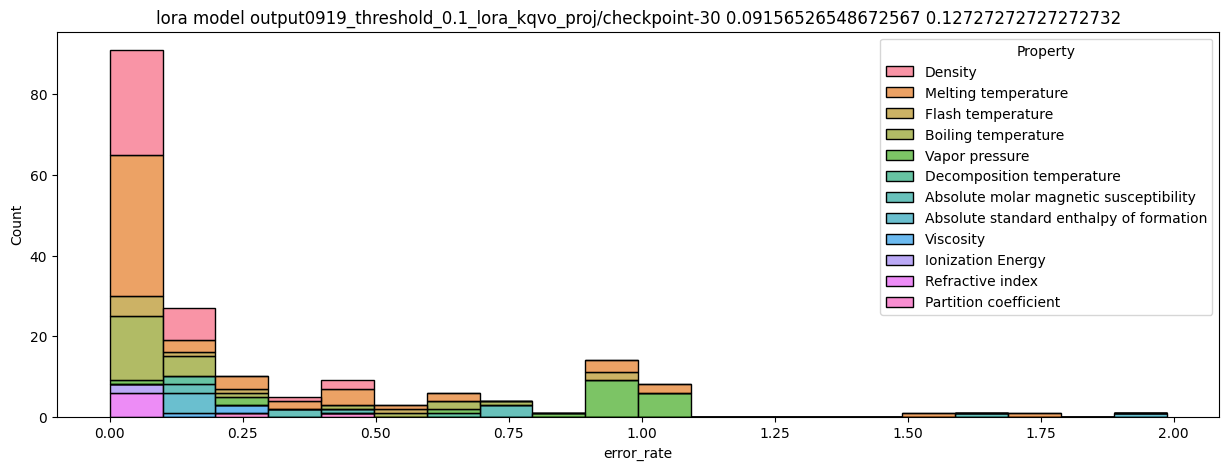

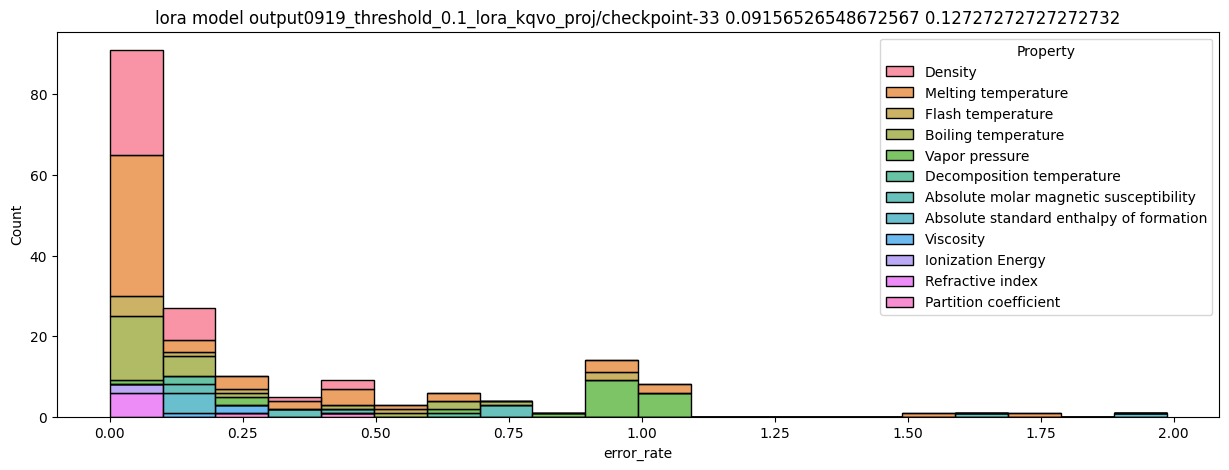

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

for lora_name,good_records in prediction_dict.items():

    df=pd.DataFrame(good_records)

    plt.figure(figsize=(15, 5))
    sns.histplot(df[df["error_rate"]<2], x="error_rate", hue="Property", multiple="stack", 
                bins=20)


    s_df=df[df["error_rate"]<1]
    median1=s_df["error_rate"].median()
    median2=df["error_rate"].median()
    plt.title(f"lora model {lora_name} {median1} {median2}")

NameError: name 'df' is not defined

: 